## 引入工具

In [1]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
# %watermark -p numpy,sklearn,pandas
# %watermark -p ipywidgets,cv2,PIL,matplotlib,plotly,netron
# %watermark -p torch,torchvision,torchaudio
# %watermark -p tensorflow,tensorboard,tflite
# %watermark -p onnx,tf2onnx,onnxruntime,tensorrt,tvm
# %matplotlib inline
# %config InlineBackend.figure_format='retina'
%config IPCompleter.use_jedi = False

# from IPython.display import display, Markdown, HTML, IFrame, Image, Javascript
# from IPython.core.magic import register_line_cell_magic, register_line_magic, register_cell_magic
# display(HTML('<style>.container { width:%d%% !important; }</style>' % 90))

import sys, os, io, logging, time, random, math
import json, base64, requests, shutil
import argparse, shlex, signal
import numpy as np

argparse.ArgumentParser.exit = lambda *arg, **kwargs: _IGNORE_

def _IMPORT(x):
    try: 
        x = x.strip()
        if x[0] == '/':
            with open(x) as fr:
                x = fr.read()
        elif 'github' in x or 'gitee' in x:
            if x.startswith('import '):
                x = x[7:]
            if x.startswith('https://'):
                x = x[8:]
            if not x.endswith('.py'):
                x = x + '.py'
            x = x.replace('blob/main/', '').replace('blob/master/', '')
            if x.startswith('raw.githubusercontent.com'):
                uri = 'https://' + x
                x = requests.get(uri)
                if x.status_code == 200:
                    x = x.text
            elif x.startswith('github.com'):
                uri = x.replace('github.com', 'raw.githubusercontent.com')
                mod = uri.split('/')
                for s in ['main', 'master']:
                    uri = 'https://' + '/'.join(mod[:3]) + s + '/'.join(mod[-3:])
                    x = requests.get(uri)
                    if x.status_code == 200:
                        x = x.text
                        break
            elif x.startswith('gitee.com'):
                mod = x.split('/')
                for s in ['/raw/main/', '/raw/master/']:
                    uri = 'https://' + '/'.join(mod[:3]) + s + '/'.join(mod[3:])
                    x = requests.get(uri)
                    if x.status_code == 200:
                        x = x.text
                        break
        exec(x, globals())
    except:
        pass

def _DIR(x, dumps=True, ret=True):
    attrs = sorted([y for y in dir(x) if not y.startswith('_')])
    result = '%s: %s' % (str(type(x))[8:-2], json.dumps(attrs) if dumps else attrs)
    if ret:
        return result
    print(result)


## 解析配置

In [2]:
_IMPORT('/data/nb_easy/easy_widget.py')

In [3]:
from utils import EVENTS

RACEURL = 'http://116.85.68.193:9119'
MSGKEY = 'nb.zmq.repnet_tf.gamma103'

with open('schema.json', 'r') as fr:
    schema_string = fr.read()
    schema_string = schema_string.replace('zmq.repnet_tf.test', MSGKEY)
    schema_string = schema_string.replace('http://host:port', RACEURL)
    schema = json.loads(schema_string)
easy = nbeasy_schema_parse(schema, events=EVENTS, debug=True);

Box(children=(Box(children=(VBox(children=(Tab(children=(VBox(children=(HBox(children=(Text(value='zmq.repnet_…

In [4]:
raise

RuntimeError: No active exception to reraise

1. https://frepai.s3.didiyunapi.com/datasets/vod/木槌加固/20211206123823.mp4

## Tools

In [4]:
import numpy as np
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.patheffects as PathEffects
from sklearn.decomposition import PCA
from scipy import stats
import pandas as pd
from sklearn import preprocessing

from matplotlib.colors import LogNorm
import itertools 
# axes = list(itertools.chain.from_iterable(axes))
from sklearn.manifold import Isomap

from scipy.signal import medfilt
import scipy.signal as signal
from statsmodels.distributions.empirical_distribution import ECDF

In [5]:
def _denormal_image(x):
    x -= x.mean()
    x /= x.std()
    x *= 64
    x += 128
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [6]:
def outlier_detection(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return np.where((data < lower_bound) | (data > upper_bound))

In [7]:
def plot_scatter(data, colors=None):
    if len(data.shape) != 2:
        xs = range(len(data))
        ys = data
    else:
        if data.shape[1] == 1:
            ys = data[:, 0]
            xs = range(len(data))
        else:
            xs = data[:, 0]
            ys = data[:, 1]
        
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    ax.scatter(xs, ys, c=colors, edgecolor='none', cmap=plt.cm.get_cmap('Paired', 2))
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('on')
    ax.axis('tight')

In [8]:
def draw_osd_sim(sim, size=128, figsize=(8, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    plt.axis('off')
    # fig.set_size_inches(size / 100.0, size / 100.0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0, wspace=0)
    plt.margins(0,0)
    plt.imshow(sim, cmap='hot', interpolation='nearest', norm=LogNorm())

In [9]:
def moving_average(arr, axis=0, wsize=3):
    return np.apply_along_axis(lambda m: np.convolve(m, np.ones(wsize)/wsize, mode='same'), axis=axis, arr=arr)

## Datasets

In [10]:
EMBS_DIR = '/data/embs'

In [439]:
%%bash

DST_DIR=/data/embs
URL_PREFIX=https://frepai.s3.didiyunapi.com/datasets/vod/outputs

# '20211201161714/1638627646'
FILES=(
    'https://frepai.s3.didiyunapi.com/live/002b359e3931/20211209/outputs/20211209185601/1639139783/embs_sims.npy'
    '20211130112549/1638626932'
    '20211201074745/1638627005'
    '20211201110905/1638627357'
    '20211203163819/1638629398'
    '20211203164823/1638627707'
    '20211203172839/1638627775'
    '20211204105928/1638627847'
    '20211204110932/1638629800'
    '20211204152111/1638627907'
    '20211206105743/1638779824'
    '20211206135855/1638779140'
    '20211208111014/1638960811'
    '20211208085922/1638962305'
    '20211208130057/1638962698'
    '20211208131101/1638965346'
    '20211207153832/1638965410'
    '20211207082623/1638965552'
    '20211206103735/1638965907'
    '20211206133847/1638968071'
    '20211207082623/1638968809'
    '20211206154939/1638968916'
    '20211206111751/1638969132'
    '20211206182646/1638969310'
    '20211206081640/1638969405'
    '20211206095719/1638969604'
    '20211206090659/1638969794'
    '20211204160127/1638970410'
    '20211204161131/1638977093'
    '20211204111936/1638977308'
    '20211204091848/1638982295'
    '20211204083832/1638982376'
    '20211206152931/1638982558'
    '20211209131345/1639031048'
    '20211209124333/1639031238'
    '20211209105308/1639031374'
    '20211209093630/1639036149'
    '20211209092622/1639036291'
    '20211209085558/1639036369'
    '20211209114313/1639037498'
    '20211209080518/1639040475'
    
    '20211201095837/1638627981'
    '20211204124008/1638629958'
    '20211204144055/1638628049'
    '20211204101912/1639042951'
    
    
    '20211209132349/1639040172' # noise
    
    
    '20211209173627/1639139427' # another machine
)

for file_ts in ${FILES[@]}
do
    if [[ ${file_ts:0:8} == 'https://' ]]
    then
        file=`echo ${file_ts:8} | cut -d/ -f6`
        if [[ ! -f $DST_DIR/${file}_feat.npy ]]
        then
            file=`echo ${file_ts:8} | cut -d/ -f6`
            echo $DST_DIR $file_ts
            wget -q -P $DST_DIR $file_ts
            echo $DST_DIR ${file_ts/sims.npy/feat.npy}
            wget -q -P $DST_DIR ${file_ts/sims.npy/feat.npy}
            mv $DST_DIR/embs_feat.npy $DST_DIR/${file}_feat.npy
            mv $DST_DIR/embs_sims.npy $DST_DIR/${file}_sims.npy
        fi
    else
        file=`echo $file_ts | cut -d/ -f1`
        if [[ ! -f $DST_DIR/${file}_feat.npy ]]
        then
            echo $DST_DIR $URL_PREFIX/$file_ts/embs_sims.npy
            wget -q -P $DST_DIR $URL_PREFIX/$file_ts/embs_sims.npy
            echo $DST_DIR $URL_PREFIX/$file_ts/embs_feat.npy
            wget -q -P $DST_DIR $URL_PREFIX/$file_ts/embs_feat.npy
            mv $DST_DIR/embs_feat.npy $DST_DIR/${file}_feat.npy
            mv $DST_DIR/embs_sims.npy $DST_DIR/${file}_sims.npy
        fi
    fi
done

In [437]:
%%bash

a='https://frepai.s3.didiyunapi.com/live/002b359e3931/20211209/outputs/20211209185601/1639139783/embs_sims.npy'
echo ${a/sims.npy/feat.npy}

https://frepai.s3.didiyunapi.com/live/002b359e3931/20211209/outputs/20211209185601/1639139783/embs_feat.npy


### Pos Datasets

In [12]:
pos_embs_files1 = [
    '20211130112549',
    '20211201074745',
    '20211201161714',
    '20211203172839',
    '20211206135855',
    '20211204152111',
    '20211201110905',
    '20211204105928',
    '20211208111014',
    '20211208085922',
    '20211208130057',
    '20211207153832',
    '20211206182646',
    '20211206081640',
    '20211206090659',
    '20211204091848',
    '20211206154939',
    '20211204160127',
    '20211209092622',
]

pos_embs_files2 = [
    '20211203164823',
    '20211204110932', # b1
    '20211208131101',
    '20211207082623',
    '20211203163819', #
    '20211206103735',
    '20211206133847',
    '20211207082623',
    '20211206111751',
    '20211206095719',
    '20211204161131',
    '20211204111936',
    '20211204083832',
    '20211206152931',
    '20211209131345', # b1
    '20211209124333',
    '20211209105308',
    '20211209085558',
    '20211209080518', # l:2
]

pos_embs_files3 = [
    '20211209093630'
]


# test 
test_files = [
    '20211209114313'
]

pos_embs_files = pos_embs_files1 + pos_embs_files2  + pos_embs_files3 
len(pos_embs_files)

39

In [13]:
pos_feat_list = []
for s in pos_embs_files:
    pos_feat_list.append(np.load(f'{EMBS_DIR}/{s}_feat.npy'))
    
pos_feat_np = np.vstack(pos_feat_list)
pos_feat_np.shape

(195, 64, 512)

In [121]:
pos_sims_list = []
for s in pos_embs_files:
    pos_sims_list.append(np.load(f'{EMBS_DIR}/{s}_sims.npy')[1:-1])
    
pos_sims_np = np.vstack(pos_sims_list)
pos_sims_np.shape

(103, 64, 64)

#### A

In [14]:
def np_info(data):
    print('%.5f' % data.min(), '%.5f' % data.max(), '%.5f' % data.mean(), '%.5f' % data.std())

In [440]:
feat_np_905 = np.load(f'{EMBS_DIR}/20211201110905_feat.npy')
feat_np_819 = np.load(f'{EMBS_DIR}/20211203163819_feat.npy') # b1-
feat_np_928 = np.load(f'{EMBS_DIR}/20211204105928_feat.npy')
feat_np_922 = np.load(f'{EMBS_DIR}/20211208085922_feat.npy')
feat_np_855 = np.load(f'{EMBS_DIR}/20211206135855_feat.npy')

feat_np_313 = np.load(f'{EMBS_DIR}/20211209114313_feat.npy')

feat_np_601 = np.load(f'{EMBS_DIR}/20211209185601_feat.npy')


feat_np_055 = np.load(f'{EMBS_DIR}/20211204144055_feat.npy')
feat_np_912 = np.load(f'{EMBS_DIR}/20211204101912_feat.npy')

feat_np_627 = np.load(f'{EMBS_DIR}/20211209173627_feat.npy')[:5] # another

feat_np_905.shape, feat_np_819.shape, feat_np_928.shape, feat_np_055.shape

((4, 64, 512), (5, 64, 512), (6, 64, 512), (6, 64, 512))

In [421]:
sims_np_905 = np.load(f'{EMBS_DIR}/20211201110905_sims.npy')
sims_np_819 = np.load(f'{EMBS_DIR}/20211203163819_sims.npy')
sims_np_928 = np.load(f'{EMBS_DIR}/20211204105928_sims.npy')
sims_np_922 = np.load(f'{EMBS_DIR}/20211208085922_sims.npy')
sims_np_855 = np.load(f'{EMBS_DIR}/20211206135855_sims.npy')

sims_np_313 = np.load(f'{EMBS_DIR}/20211209114313_sims.npy')


sims_np_055 = np.load(f'{EMBS_DIR}/20211204144055_sims.npy')
sims_np_912 = np.load(f'{EMBS_DIR}/20211204101912_sims.npy')

In [17]:
# pos

feat_np_905_512 = feat_np_905.reshape(-1, 512)
feat_np_819_512 = feat_np_819.reshape(-1, 512)
feat_np_928_512 = feat_np_928.reshape(-1, 512)
feat_np_922_512 = feat_np_922.reshape(-1, 512)

feat_np_855_512 = feat_np_855.reshape(-1, 512) # 2

feat_np_313_512 = feat_np_313.reshape(-1, 512) # test

# neg

feat_np_055_512 = feat_np_055.reshape(-1, 512)
feat_np_912_512 = feat_np_912.reshape(-1, 512)

#### KSTest

In [298]:
scaler1 = preprocessing.StandardScaler()
scaler2 = preprocessing.MinMaxScaler()
scaler3 = preprocessing.RobustScaler(quantile_range=(25., 75.))
scaler4 = preprocessing.Normalizer()
NC = 128
pca = PCA(n_components=NC)
ios = Isomap(n_components=NC)
# tril = np.tril_indices(64)
# tsne = TSNE(n_components=2, random_state=0)

In [286]:
feat_data1 = []
for file in pos_embs_files1:
     feat_data1.append(np.load(f'{EMBS_DIR}/{file}_feat.npy'))
data_feat1 = np.concatenate(feat_data1, axis=0)
data_feat1.shape

(105, 64, 512)

In [287]:
feat_data2 = []
for file in pos_embs_files2:
     feat_data2.append(np.load(f'{EMBS_DIR}/{file}_feat.npy'))
data_feat2 = np.concatenate(feat_data2, axis=0)
data_feat2.shape

(87, 64, 512)

In [288]:
feat_data3 = []
for file in pos_embs_files3:
     feat_data3.append(np.load(f'{EMBS_DIR}/{file}_feat.npy'))
data_feat3 = np.concatenate(feat_data3, axis=0)
data_feat3.shape

(3, 64, 512)

In [289]:
data1 = data_feat1.reshape((-1, 512))
data2 = data_feat2.reshape((-1, 512))
data3 = data_feat3.reshape((-1, 512))
data = np.concatenate([data1, data2, data3], axis=0)

In [444]:
cdata = data.copy()
scaler = scaler4

kspca = pca

# filter_func = lambda x: moving_average(x, wsize=3)
# filter_func = lambda x: signal.medfilt2d(x, kernel_size=(3,1))
# filter_func = lambda x: np.diff(x, axis=0, prepend=0)
filter_func = lambda x: x

cdata = filter_func(cdata)

scaler.fit(cdata)
data_out = kspca.fit_transform(scaler.transform(cdata))

ecdf = [ECDF(sample) for sample in data_out.T]

# print(kspca.explained_variance_ratio_)

def embedding_accuracy(test, main, alpha=0.01):
    pvals = np.array([stats.ks_2samp(test[:, i], data_out[:, i])[1] for i in range(test.shape[-1])])
    return sum(kspca.explained_variance_ratio_[pvals > alpha])
    # return np.mean(pvals > alpha)
     
def empirical_kstest(test, ecdf, alpha=0.01):
    pvals = np.array([stats.kstest(test[:, i], cdf=lambda x: ecdf[i](x))[1] for i in range(test.shape[-1])])
    return sum(kspca.explained_variance_ratio_[pvals > alpha])
    # return np.mean(pvals > alpha)
    
sum(kspca.explained_variance_ratio_) / 2

0.42354095104383305

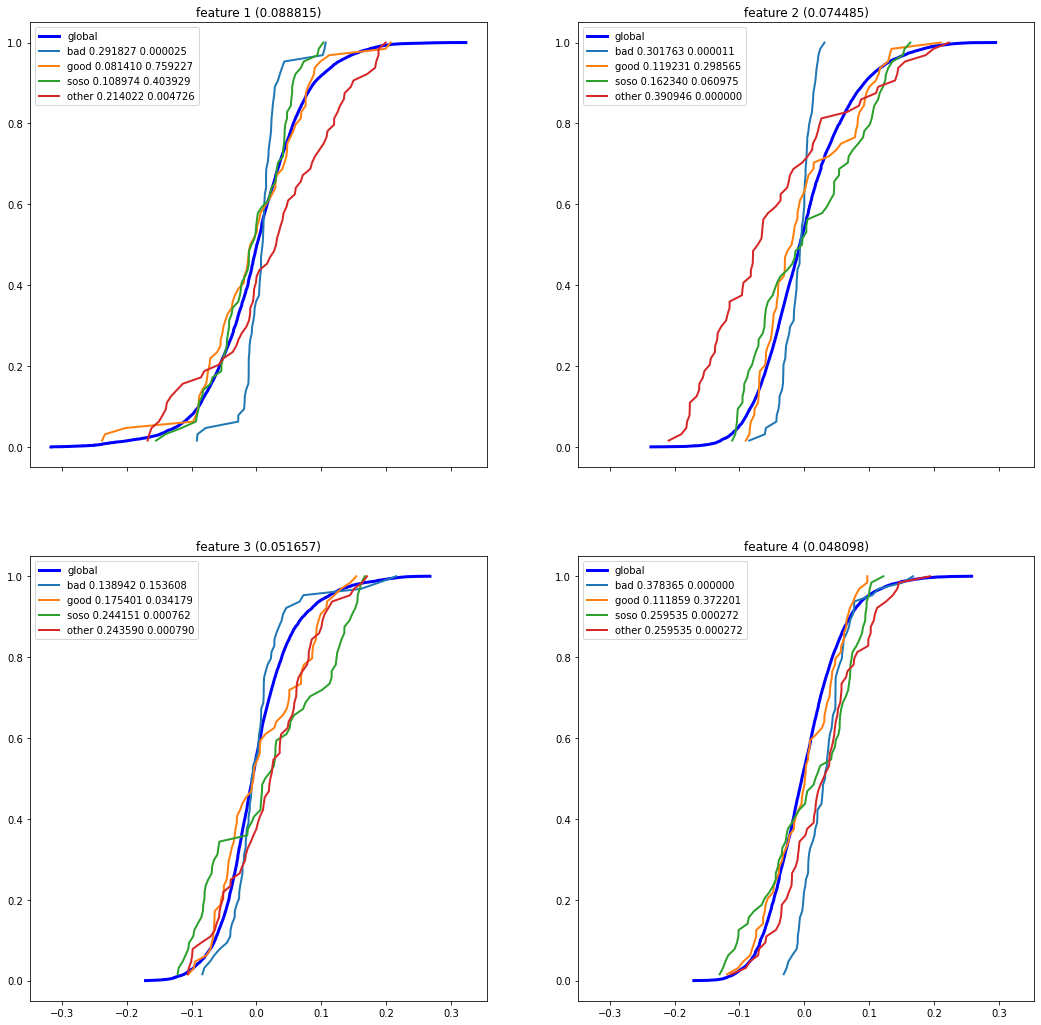

In [424]:
fig, axes = plt.subplots(2, 2, figsize=(18, 18), sharex=True)
axes = list(itertools.chain.from_iterable(axes))
for i in range(len(axes)):
    axes[i].set_title('feature %d (%.6f)' % (i + 1, kspca.explained_variance_ratio_[i]))
    axes[i].plot(ecdf[i].x, ecdf[i].y, color='b', lw=3, label='global');
    for label, feat in (('bad', feat_np_055), ('good', feat_np_922), ('soso', feat_np_855), ('other', feat_np_627)):
        out = kspca.transform(scaler.transform(feat[1]))
        cdf = ECDF(out.T[i])
        statistic, pvalue = stats.kstest(out.T[i], cdf=lambda x: ecdf[i](x))
        axes[i].plot(cdf.x, cdf.y, lw=2, label='%s %.6f %.6f'%(label, statistic, pvalue));
    axes[i].legend();

In [423]:
for feat in (feat_np_055, feat_np_912, feat_np_627):
    print('')
    for f in feat:
        f = filter_func(f)
        out = kspca.transform(scaler.transform(f))
        print('%.6f' % empirical_kstest(out, ecdf), end='\t')


0.366251	0.269743	0.374854	0.179355	0.281497	0.213747	
0.333090	0.296269	0.336155	0.149895	0.314837	0.219530	0.000000	
0.216413	0.165725	0.126878	0.266526	0.174569	

In [442]:
for feat in (feat_np_922, feat_np_905, feat_np_601):
    print('')
    for f in feat:
        f = filter_func(f)
        out = kspca.transform(scaler.transform(f))
        print('%.6f' % empirical_kstest(out, ecdf), end='\t')


0.463535	0.585085	0.385845	
0.371635	0.523607	0.421235	0.313334	
0.439886	0.331289	0.462828	0.542151	0.451235	0.474509	0.512969	0.535135	0.491144	0.000000	

In [443]:
feat_np_601.shape

(10, 64, 512)

In [322]:
for feat in (feat_np_855, feat_np_313):
    print('')
    for f in feat:
        f = filter_func(f)
        out = kspca.transform(scaler.transform(f))
        print('%.6f' % empirical_kstest(out, ecdf), end='\t')


0.551089	0.528747	0.453001	0.482319	0.000000	
0.337015	0.242057	0.306189	0.609690	0.090056	

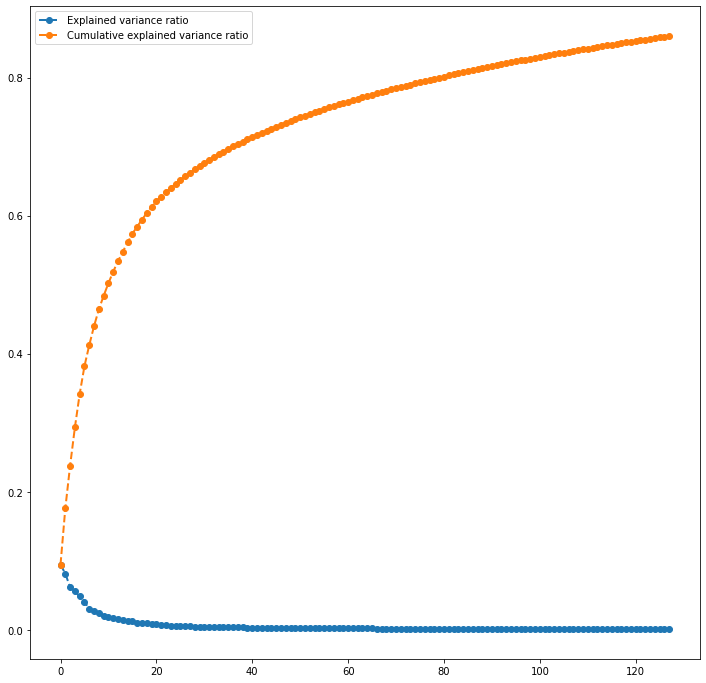

In [317]:
_, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.plot(
    kspca.explained_variance_ratio_, "--o", linewidth=2,
    label="Explained variance ratio"
)
ax.plot(
    kspca.explained_variance_ratio_.cumsum(), "--o", linewidth=2,
    label="Cumulative explained variance ratio"
)

ax.legend(loc="best", frameon=True);

In [ ]:
draw_osd_sim(np.concatenate(sims_np_055, axis=1), figsize=(sims_np_055.shape[0] * 4, 8))

In [ ]:
draw_osd_sim(np.concatenate(sims_np_922, axis=1), figsize=(sims_np_922.shape[0] * 4, 8))

In [ ]:
draw_osd_sim(np.concatenate(sims_np_819, axis=1), figsize=(sims_np_819.shape[0] * 4, 8))

In [ ]:
pd.DataFrame(neg_outs[0]).describe()

In [ ]:
pd.DataFrame(pos1_outs[0]).describe()

### A1

In [ ]:
pca4 = PCA(n_components=4)
feat_np_905_out = pca4.fit_transform(feat_np_905_512)
np.cumsum(pca4.explained_variance_ratio_)[-1]

In [ ]:
np_info(feat_np_905_out[:, 0])

In [ ]:
feat_np_819_out = pca4.fit_transform(feat_np_819_512)
np.cumsum(pca4.explained_variance_ratio_)[-1]

In [ ]:
np_info(feat_np_819_out[:, 0])

In [ ]:
feat_np_928_out = pca4.fit_transform(feat_np_928_512)
np.cumsum(pca4.explained_variance_ratio_)[-1]

In [ ]:
np_info(feat_np_928_out[:, 0])

In [ ]:
feat_np_055_out = pca4.transform(feat_np_055_512)
np.cumsum(pca4.explained_variance_ratio_)[-1]

In [ ]:
np_info(feat_np_055_out[:, 0])

#### B

In [ ]:
a = pos_feat_np.reshape((-1, 512))

In [ ]:
feats = []
for feat in a:
    feats.append(_denormal_image(feat))

In [ ]:
feats_np = np.vstack(feats)

In [ ]:
feats_np.shape

In [ ]:
pca = PCA(n_components=64)
pca.fit(feats_np)

In [ ]:
np.cumsum(pca.explained_variance_ratio_)[-1]

In [ ]:
plot_scatter(np.cumsum(pca.explained_variance_ratio_))

In [ ]:
pos_feat_64 = pca.transform(feats_np)

pos_feat_64_0 = pos_feat_64 - pos_feat_64.mean(axis=0)
pos_feat_64_1 = pos_feat_64_0 - pos_feat_64_0.mean(axis=1).reshape((-1, 1))

plot_scatter(pos_feat_64_1)

In [ ]:
plt.figure(figsize=(24, 24))
plt.imshow(b[10:64])

### Neg Datasets

In [ ]:
neg_embs_files = (
    '20211201095837',
    '20211204124008',
    '20211204144055',
)

In [ ]:
neg_feat_list = []
for s in neg_embs_files:
    neg_feat_list.append(np.load(f'{EMBS_DIR}/{s}_feat.npy'))
    
neg_feat_np = np.vstack(neg_feat_list)
neg_feat_np.shape

In [ ]:
neg_sims_list = []
for s in neg_embs_files:
    neg_sims_list.append(np.load(f'{EMBS_DIR}/{s}_sims.npy')[1:-1])
    
neg_sims_np = np.vstack(neg_sims_list)
neg_sims_np.shape

## PCA

### Feat

In [ ]:
pos_feat_512 = pos_feat_np.reshape((-1, 512)).copy()
neg_feat_512 = neg_feat_np.reshape((-1, 512)).copy()
pos_feat_512.shape, neg_feat_512.shape

In [ ]:
pos_feat_512_0 = pos_feat_512 - pos_feat_512.mean(axis=0)
pos_feat_512_1 = pos_feat_512_0 - pos_feat_512_0.mean(axis=1).reshape((-1, 1))

plot_scatter(pos_feat_512_1)

In [ ]:
neg_feat_512_0 = neg_feat_512 - neg_feat_512.mean(axis=0)
neg_feat_512_1 = neg_feat_512_0 - neg_feat_512_0.mean(axis=1).reshape((-1, 1))

plot_scatter(neg_feat_512_1)
# neg_feat_512_1[100:120]

In [ ]:
neg_feat_512_0 = neg_feat_512 - pos_feat_512.mean(axis=0)
neg_feat_512_1 = neg_feat_512_0 - neg_feat_512_0.mean(axis=1).reshape((-1, 1))

plot_scatter(neg_feat_512_1)
# neg_feat_512_1[100:120]

In [ ]:
targets = [0] * pos_feat_512.shape[0] + [1] * neg_feat_512.shape[0]
# plot_scatter(pos_output, colors=targets)
plot_scatter(np.vstack([pos_feat_512_1, neg_feat_512_1]), colors=targets)

In [ ]:
pca = PCA(n_components=32)
pca.fit(pos_feat_512)

In [ ]:
pos_feat_512[1, :10]

In [ ]:
np.cumsum(pca.explained_variance_ratio_)[-1]

In [ ]:
# pos_feat_32 = pca.transform(np.concatenate([pos_feat_512, neg_feat_512], axis=0))
pos_feat_32 = pca.transform(pos_feat_512)
neg_feat_32 = pca.transform(neg_feat_512)

In [ ]:
len(pos_feat_512)

In [ ]:
neg_feat_32.shape

In [ ]:
np.percentile(pos_feat_32[:, 0], [25, 75])

In [ ]:
indexes = []
means = []
stds = []
for i in range(32):
    indexes.append(outlier_detection(pos_feat_32[:, i])[0])
    means.append(pos_feat_32[:, i].mean())
    stds.append(pos_feat_32[:, i].std())

In [ ]:
# means, stds

In [ ]:
for f in neg_feat_32:
    flg = 0
    for i in range(32):
        f[i] - means
        print()

In [ ]:
outlier_index = np.unique(np.concatenate(indexes))

In [ ]:
len(outlier_index)

In [ ]:
outlier_index[-300:]

In [ ]:
outlier_detection(pos_feat_32[:, 0])

In [ ]:
pos_feat_64 = pca.transform(pos_feat_512_1)
neg_feat_64 = pca.transform(neg_feat_512_1)

In [ ]:
targets = [0] * pos_feat_64.shape[0] + [1] * neg_feat_64.shape[0]
plot_scatter(np.vstack([pos_feat_64, neg_feat_64]), colors=targets)

In [ ]:
pos_output_1 = pca.fit_transform(pos_feat_512)
pos_output_2 = pca.fit_transform(neg_feat_512)

In [ ]:
targets = [0] * pos_feat_512.shape[0] + [1] * neg_feat_512.shape[0]
# plot_scatter(pos_output, colors=targets)
plot_scatter(np.vstack([pos_output_1, pos_output_2]), colors=targets)

### Sims

In [ ]:
tril = np.tril_indices(64)

In [ ]:
pos_sims_tril = pos_sims_np[:, tril[0], tril[1]]
neg_sims_tril = neg_sims_np[:, tril[0], tril[1]]

In [ ]:
pos_sims_tril.shape, neg_sims_tril.shape

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline_sims = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=2))])
# pca_sims = PCA(n_components=2)
# pca_sims.fit(pos_sims_tril)
pipeline_sims.fit(pos_sims_tril)

In [ ]:
pca = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=10))])

In [ ]:
pca.fit(pos_sims_tril)

In [ ]:
pca['pca'].explained_variance_ratio_

In [ ]:
# !pip3 install pyod  --trusted-host  mirrors.aliyun.com -i https://mirrors.aliyun.com/pypi/simple

In [ ]:
from pyod.models.pca import PCA

In [ ]:
clf = PCA(n_components=2)
clf.fit(pos_sims_tril)

In [ ]:
print(clf.labels_)

In [ ]:
clf.predict(neg_sims_tril)

In [ ]:
pos_sims_output = pipeline_sims.transform(pos_sims_tril)
neg_sims_output = pipeline_sims.transform(neg_sims_tril)
pos_sims_output.shape, neg_sims_output.shape

In [ ]:
pos_sims_output.std(), neg_sims_output.std(), pos_sims_output.mean(), neg_sims_output.mean()

In [ ]:
neg_sims_output

In [ ]:
pos_sims_output = pca_sims.transform(pos_sims_tril)
neg_sims_output = pca_sims.transform(neg_sims_tril)
pos_sims_output.shape, neg_sims_output.shape

In [ ]:
targets = [0] * pos_sims_tril.shape[0] + [1] * neg_sims_tril.shape[0]
plot_scatter(np.vstack([pos_sims_output, neg_sims_output]), colors=targets)

## A

In [ ]:
sims = ('20211130112549', '20211201074745', '20211201110905', '20211201161714')
pos_sims_list = []
for s in sims:
    pos_sims_list.append(np.load(f'/data/sims/{s}.npy'))
    
neg_sims = np.load(f'/data/sims/20211130112549.npy')

In [ ]:
pca0 = PCA()

In [ ]:
pca = PCA(n_components=2)

In [ ]:
data = np.vstack(pos_sims_list) # np.concatenate(sims_list)

In [ ]:
il1 = np.tril_indices(64)

In [ ]:
neg_features = neg_sims[:, il1[0], il1[1]]
neg_features.shape

In [ ]:
neg_features.var(axis=1)

In [ ]:
features = data[:, il1[0], il1[1]]

In [ ]:
features.shape

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

In [ ]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
features.shape

In [ ]:
pca0 = PCA().fit(features)
plt.plot(np.cumsum(pca0.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
pca_pos_out = pca.fit_transform(features)
pca_pos_out.var(), pca_pos_out.mean()

In [ ]:
pca_pos_out.std(axis=1)

In [ ]:
pca_neg_out = pca.fit_transform(neg_features)
pca_neg_out.var(), pca_neg_out.mean()

In [ ]:
pca_neg_out.std(axis=1)

In [ ]:
pca.explained_variance_

In [ ]:
pca.mean_, pca.explained_variance_ratio_

In [ ]:
plot_scatter(pca_pos_out)

In [ ]:
plot_scatter(pca_neg_out)

### TSNE

In [ ]:
tsne = TSNE(random_state=0)

In [ ]:
Xt = pca.fit_transform(features)
plt.scatter(Xt[:,0], Xt[:,1])

In [ ]:
Nt = pca.transform(neg_features)
plt.scatter(Nt[:,0], Nt[:,1])

In [ ]:
pca.explained_variance_ratio_

In [ ]:
tsne_results = tsne.fit_transform(features)

In [ ]:
plot_scatter(tsne_results)

### B

In [ ]:
qg_embs1 = np.load('/data/repnet_embs_qg_1.npy')
qg_embs1.shape

In [ ]:
qg_features_1 = qg_embs1[1:10].reshape(-1, 512)
qg_features_1.shape

In [ ]:
qg_tsne_1 = tsne.fit_transform(qg_features_1)

In [ ]:
plot_scatter(qg_tsne_1)

## D

```py
    def remover_outlier(self, x_pca, y_pca, x, y, label):
        # outlier_index = np.where((x_pca[:, 0:5] < -200) | (x_pca[:, 0:5] > 35))[0]
        outlier_x =[]
        for i in range(x_pca.shape[1]):
            outlier_x.append(self.outlier_detection(x_pca[:, i])[0])
        outlier_index = np.unique(np.concatenate(outlier_x))

        x_pca = np.delete(x_pca, outlier_index, axis=0)
        y_pca = np.delete(y_pca, outlier_index, axis=0)
        x = np.delete(x, outlier_index, axis=0)
        y = np.delete(y, outlier_index, axis=0)
        label = label.drop(index=outlier_index).reset_index(drop=True)
        return x_pca, y_pca, x, y, label

    def outlier_detection(self, data):
        q1, q3 = np.percentile(data, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - (iqr * 1.5)
        upper_bound = q3 + (iqr * 1.5)
        return np.where((data < lower_bound) | (data > upper_bound))
```

In [233]:
sc = preprocessing.StandardScaler()
# a = np.random.randn(1024, 1)*0.4 + 1
a = np.arange(0, 1024).reshape(1024, 1)
b = sc.fit_transform(a)
params = stats.norm.fit(a)
print(params)
print(a.mean(), a.std(), b.mean(), b.std(), sc.mean_, np.sqrt(sc.var_))
print(stats.kstest(a[:, 0], "norm", args=params))
print(stats.kstest(b.reshape(-1,), "norm", args=(0, 1)))

(511.5, 295.60319687039924)
511.5 295.60319687039924 -1.1102230246251565e-16 0.9999999999999999 [511.5] [295.60319687]
KstestResult(statistic=0.05769501054112536, pvalue=0.002099347216060239)
KstestResult(statistic=0.05769501054112536, pvalue=0.002099347216060239)


https://github.com/eringong/great_expectations/blob/6e92d009cc8d52b48c951ebb1ddf042b220a8690/great_expectations/dataset/pandas_dataset.py
https://machinelearningmastery.com/empirical-distribution-function-in-python/